##### Building a hybrid anomaly detection model combining a sparse autoencoder, Isolation Forest, and SVM begins by loading and cleaning your data. Select key features and split the data into training and testing sets. Normalize the data through feature scaling, which is crucial for the model's accuracy. First, use a sparse autoencoder for dimensionality reduction, making the data more manageable and focused. Then, apply an Isolation Forest to efficiently identify potential outliers, followed by an SVM to refine, and confirm the detection of anomalies with precise boundaries. Evaluate the model's effectiveness using precision, recall, the F1-score, and a confusion matrix. This sequential approach harnesses the strengths of each model component, ensuring comprehensive and effective anomaly detection.

In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

Epoch 1/50
191/191 [==============================] - 1s 1ms/step - loss: 491.2609
Epoch 2/50
191/191 [==============================] - 0s 1ms/step - loss: 490.7078
Epoch 3/50
191/191 [==============================] - 0s 1ms/step - loss: 490.6960
Epoch 4/50
191/191 [==============================] - 0s 1ms/step - loss: 490.6858
Epoch 5/50
191/191 [==============================] - 0s 1ms/step - loss: 490.6796
Epoch 6/50
191/191 [==============================] - 0s 2ms/step - loss: 490.6760
Epoch 7/50
191/191 [==============================] - 0s 1ms/step - loss: 490.6739
Epoch 8/50
191/191 [==============================] - 0s 1ms/step - loss: 490.6724
Epoch 9/50
191/191 [==============================] - 0s 2ms/step - loss: 490.6713
Epoch 10/50
191/191 [==============================] - 0s 2ms/step - loss: 490.6697
Epoch 11/50
191/191 [==============================] - 0s 2ms/step - loss: 490.6686
Epoch 12/50
191/191 [==============================] - 0s 2ms/step - loss: 490.6674
E

C:\Users\sebha\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sebha\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sebha\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sebha\anaconda3\lib\site-packages\sklearn\metrics\_classifi

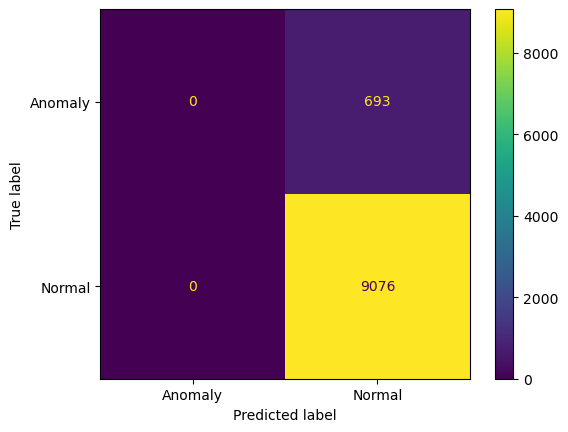

In [6]:

def hybrid_anomaly_detection():

    
    # Load data from a CSV file   
    data = pd.read_csv('adultdata.csv')
    
    #convert all the values in the columns into numeric
    label_encoder = LabelEncoder()
    for column in data.select_dtypes(include=['object']).columns:
        data[column] = label_encoder.fit_transform(data[column])
    
    data = data.drop('Sex', axis=1)
    
    X = data.drop('fnlwgt', axis=1)  # Assuming 'target' is the column name of the continuous target variable
    y_cont = data['fnlwgt']
    
    y = np.where(y_cont > 50000, 1, 0)  # Define `threshold` based on your domain knowledge
    
    # Select top k features; k might be adjusted based on the dataset
    selector = SelectKBest(f_classif, k=10)
    X_selected = selector.fit_transform(X, y)
    
    #data.info()

    data.dropna(axis=0, inplace=True)
    
    
    
    
    # Build and train sparse autoencoder
    input_dim = X_selected.shape[1]
    encoding_dim = 32
    input_layer = Input(shape=(input_dim,))
    encoder = Dense(encoding_dim, activation='relu', activity_regularizer=regularizers.l1(10e-5))(input_layer)
    decoder = Dense(input_dim, activation='sigmoid')(encoder)
    autoencoder = Model(inputs=input_layer, outputs=decoder)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    autoencoder.fit(X_selected, X_selected, epochs=50, batch_size=256, shuffle=True)
    
    # Encode the data
    encoder_model = Model(inputs=autoencoder.input, outputs=autoencoder.layers[1].output)
    X_encoded = encoder_model.predict(X_selected)
    
    # Split the data into train and test after encoding
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
    
    # Scale the features after splitting
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Use Isolation Forest
    iso = IsolationForest(contamination=0.1, random_state=42)
    iso.fit(X_train_scaled)
    iso_preds = iso.predict(X_train_scaled)
    
    # Use the outcome that is identified as normal only
    normal_data_indices = np.where(iso_preds == 1)[0]
    normal_data = X_train_scaled[normal_data_indices]
    normal_labels = y_train[normal_data_indices]
    
    # Train a new Isolation Forest on the normal data
    iso2 = IsolationForest(contamination=0.1, random_state=42)
    iso2.fit(normal_data)
    
    # Fit the SVM on the output of the second Isolation Forest
    svm = SVC(kernel='rbf')
    svm.fit(normal_data, normal_labels)
    
    # Predict on the test data
    svm_preds = svm.predict(X_test_scaled)
    
    # Evaluate the final outcome
    precision = precision_score(y_test, svm_preds, average='weighted')
    recall = recall_score(y_test, svm_preds, average='weighted')
    f1 = f1_score(y_test, svm_preds, average='weighted')
    
    print(f'Precision: {precision:.3f}, Recall: {recall:.3f}, F1 Score: {f1:.3f}')
    
    print(classification_report(y_test, svm_preds))
    
#     # Visualize the outcome with a confusion matrix
#     cm = confusion_matrix(y_test, svm_preds)
#     plt.imshow(cm, cmap='Blues')
#     plt.title('Confusion Matrix')
#     plt.colorbar()
#     plt.xticks(np.arange(len(np.unique(y_test))), np.unique(y_test))
#     plt.yticks(np.arange(len(np.unique(y_test))), np.unique(y_test))
#     plt.xlabel('Predicted labels')
#     plt.ylabel('True labels')
#     plt.show()
    
            # Display the confusion matrix
    cm = confusion_matrix(y_test, svm_preds, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Anomaly', 'Normal'])
    disp.plot()
    plt.show()

# Example usage

hybrid_anomaly_detection()